In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import evalml
import woodwork as ww
from evalml import AutoMLSearch
from evalml.model_understanding.metrics import graph_confusion_matrix
from evalml.pipelines import PipelineBase

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os

import warnings

C:\Users\okmic\.conda\envs\alteryx\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\okmic\.conda\envs\alteryx\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

### Dataset

In [2]:
label = 'is_promoted'
data = pd.read_csv('../../data/employee_promotion.csv')
print(data.shape)
data.head()

(54808, 13)


employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  awards_won  avg_training_score  is_promoted  
0                  8           0                49.0            0  
1                  4           0                60.0            0  
2                  7           0                50.0            0  
3                 10           0                50.0            0  
4                  2           0                73.0            0

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won            54808 non-null  int64  
 11  avg_training_score    52248 non-null  float64
 12  is_promoted           54808 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 5.4+ MB


In [4]:
print(data[label].value_counts())

0    50140
1     4668
Name: is_promoted, dtype: int64


In [5]:
# remove not required column for this exercise
data.drop(columns=['employee_id'], axis=1, inplace=True)

In [6]:
categorical_values = [col for col in data.columns if data[col].dtype == 'object']
data[categorical_values].nunique()

department              9
region                 34
education               3
gender                  2
recruitment_channel     3
dtype: int64

### Dealing with NAs

In [7]:
data.isnull().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won                 0
avg_training_score      2560
is_promoted                0
dtype: int64

In [8]:
data.education.value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

Because we have a case of employees with imcomplete data, we should look to exclude these from the promotion exercise.
That said, is it possible to see other info for these employees to be excluded

In [9]:
exc_employees = data.loc[data.isna().sum(axis=1) != 0, :]
print(exc_employees.shape)

exc_employees.head()

(8428, 12)


department     region   education gender recruitment_channel  \
10         Technology  region_23         NaN      m            sourcing   
21         Operations  region_15         NaN      m            sourcing   
23        Procurement   region_5  Bachelor's      m               other   
29  Sales & Marketing   region_4  Bachelor's      m            sourcing   
31            Finance  region_31  Bachelor's      m               other   

    no_of_trainings  age  previous_year_rating  length_of_service  awards_won  \
10                1   30                   NaN                  1           0   
21                1   41                   4.0                 11           0   
23                1   27                   NaN                  1           0   
29                1   26                   NaN                  1           0   
31                2   26                   1.0                  2           0   

    avg_training_score  is_promoted  
10                77.0            0  
21                57.0            0  
23                70.0            0  
29                44.0            0  
31                 NaN            0

<Axes: xlabel='length_of_service', ylabel='Count'>

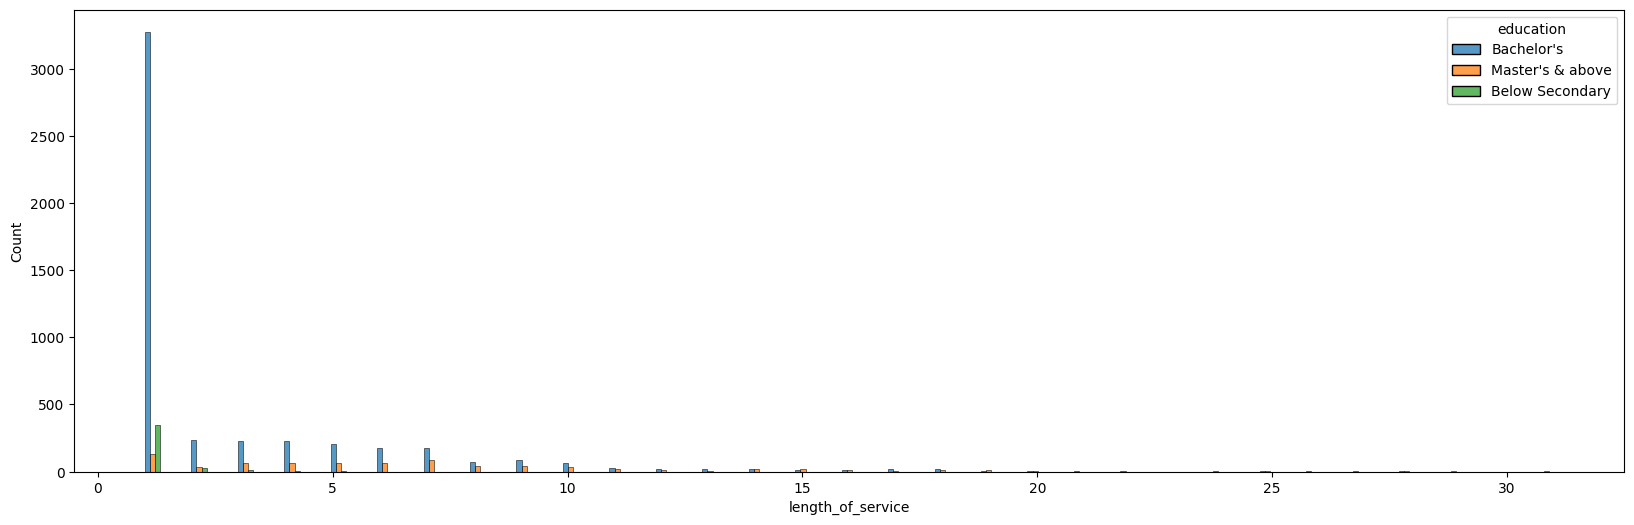

In [10]:
# na columns are education, previous_year_rating and avg_training_score
fig, ax = plt.subplots(figsize=(20, 6))
sns.histplot(exc_employees, x='length_of_service', hue='education', multiple="dodge", ax=ax)

In [11]:
# assign 0 for previous_years_rating all employees that are just a year in service, 
# didn't have previous_year_rating and have their education data available
data.loc[(data['length_of_service'] == 1) & (data['previous_year_rating'].isna()) & (data['education'].notna()), :] = 0
data.isna().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating     385
length_of_service          0
awards_won                 0
avg_training_score      2377
is_promoted                0
dtype: int64

In [12]:
exc_employees = data.loc[data.isna().sum(axis=1) != 0, :]
print(exc_employees.shape)

exc_employees.head()

(4689, 12)


department     region   education gender recruitment_channel  \
10         Technology  region_23         NaN      m            sourcing   
21         Operations  region_15         NaN      m            sourcing   
31            Finance  region_31  Bachelor's      m               other   
32  Sales & Marketing   region_7         NaN      f            sourcing   
43  Sales & Marketing   region_2         NaN      m               other   

    no_of_trainings  age  previous_year_rating  length_of_service  awards_won  \
10                1   30                   NaN                  1           0   
21                1   41                   4.0                 11           0   
31                2   26                   1.0                  2           0   
32                1   24                   1.0                  2           0   
43                3   24                   2.0                  2           0   

    avg_training_score  is_promoted  
10                77.0            0  
21                57.0            0  
31                 NaN            0  
32                48.0            0  
43                48.0            0

<Axes: xlabel='length_of_service', ylabel='Count'>

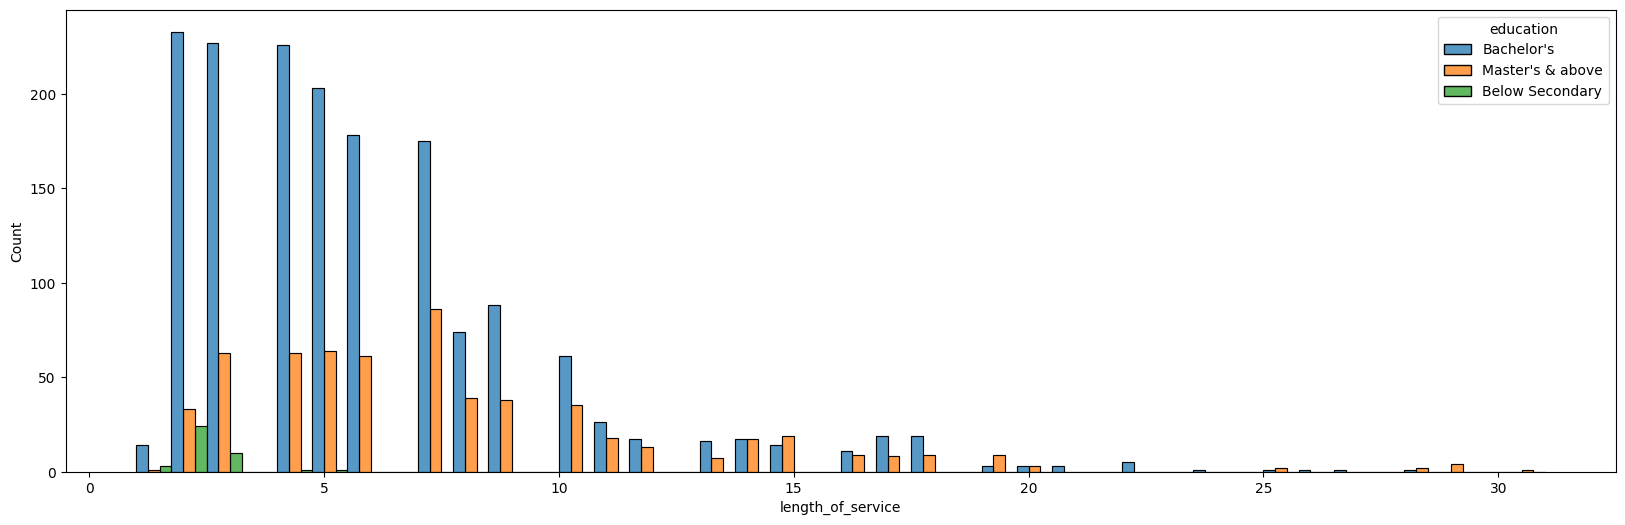

In [13]:
# na columns are education, previous_year_rating and avg_training_score
fig, ax = plt.subplots(figsize=(20, 6))
sns.histplot(exc_employees, x='length_of_service', hue='education', multiple="dodge", ax=ax)

In [14]:
# except for getting better data, we will drop all other nulls/nas.
data = data.dropna()

### Data Analysis

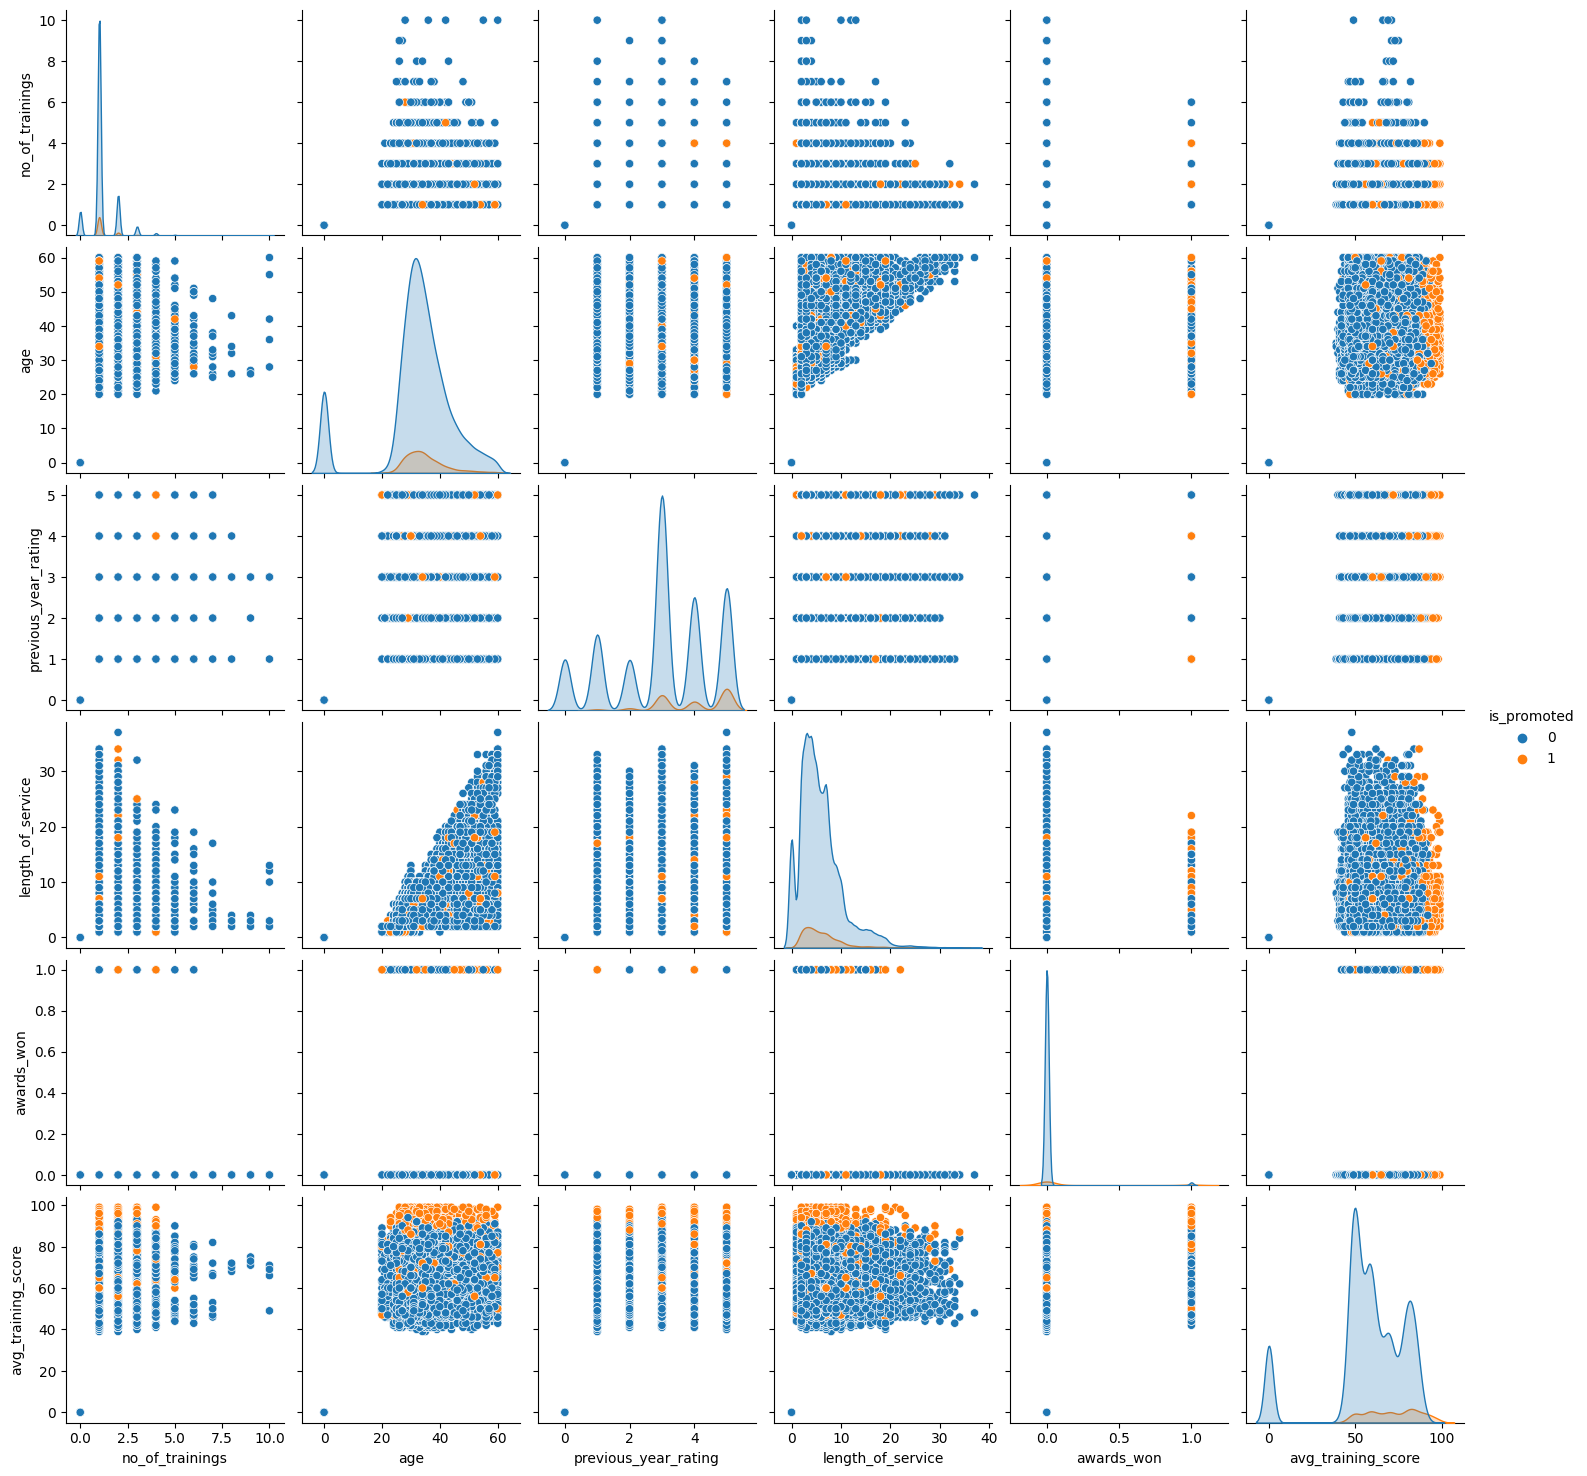

In [15]:
sns.pairplot(data, hue=label)

### Create splits

In [16]:
data.ww.init(name='employee_evaluation')
data.ww.set_types(
    {
        "department": "Categorical", 
        "region": "Categorical", 
        "education": "Categorical", 
        "gender": "Categorical", 
        "recruitment_channel": "Categorical", 
        "no_of_trainings": "IntegerNullable", 
        "age": "Integer", 
        "previous_year_rating": "Double",
        "length_of_service" : "Integer",
        "awards_won" : "Integer",
        "avg_training_score" : "Double",
        label : "Integer"
    }
)

In [17]:
def do_splits(df):
    X = df.drop(columns=[label])
    y = df[label]
    return train_test_split(X, y, test_size=0.20, shuffle=True, random_state=10)

train_X, test_X, train_y, test_y = do_splits(data)
print(f'train_X shape is {train_X.shape}')
print(f'train_y shape is {train_y.shape}')
print(f'test_X shape is {test_X.shape}')
print(f'test_y shape is {test_y.shape}')


train_X shape is (40095, 11)
train_y shape is (40095,)
test_X shape is (10024, 11)
test_y shape is (10024,)


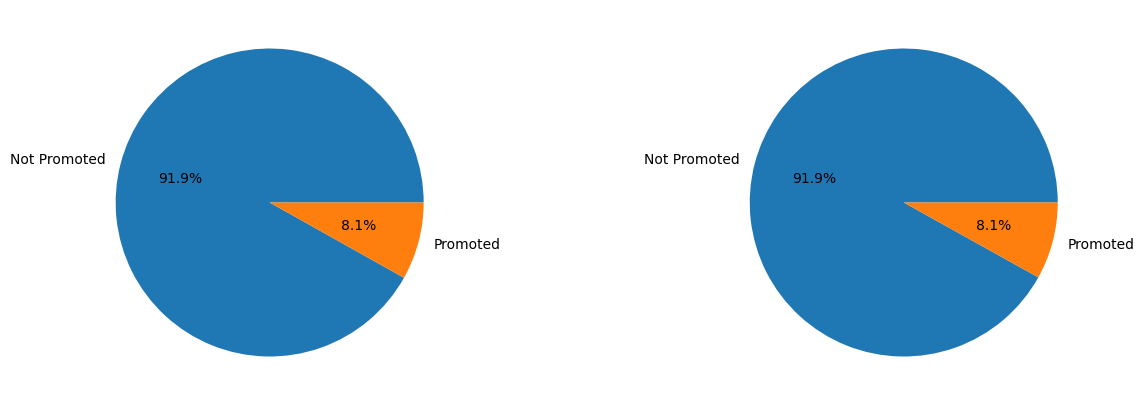

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

pie_labels = ['Not Promoted', 'Promoted']
training_dist = train_y.value_counts()
testing_dist = test_y.value_counts()
axs[0].pie(training_dist, labels=pie_labels, autopct='%1.1f%%')
axs[1].pie(testing_dist, labels=pie_labels, autopct='%1.1f%%')

plt.show()

# ax.pie(sizes, labels=labels)

### AutoML traiing with EvalML

In [19]:
automl = AutoMLSearch(
    X_train=train_X,
    y_train=train_y,
    problem_type="binary",
#     objective='precision',                     # shocking, I did better commenting out these lines
#     additional_objectives=["auc", "f1"],
    max_batches=4,
    optimize_thresholds=True,
    verbose=True,
)

automl.search(interactive_plot=True)

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Binary. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 4 batches for a total of None pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type': 'scatter',
              'uid': '50c74b22-086a-4798-8dd7-6a71c6c8a0e2',
              'x': [],
              'y': []},
             {'marker': {'color': 'gray'},
              'mode': 'markers',
              'name': 'Iter score',
              'type': 'scatter',
              'uid': '46161fee-8fed-48f4-bb70-e93117d9983d',
              'x': [],
              'y': []}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': ('Pipeline Search: Iteration vs.' ... 'ore at current iteration</sub>')},
               'xaxis': {'rangemode': 'tozero', 'title': {'text': 'Iteration'}},
               'yaxis': {'title': {'text': 'Validation Score'}}}
})

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 2.931

*****************************
* Evaluating Batch Number 1 *
*****************************

Random Forest Classifier w/ Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.280

*****************************
* Evaluating Batch Number 2 *
*****************************

Random Forest Classifier w/ Label Encoder + Imputer + One Hot Encoder + Undersampler + RF Classifier Select From Model:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.274

*****************************
* Evaluating Batch Number 3 *
*****************************

Decision Tree Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Co

XGBoost Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.279
LightGBM Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.302
Elastic Net Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Standard Scaler + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Standard Scaler + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.241
XGBoost Classifier w/ Label Encoder + Select Columns By 

	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.241
XGBoost Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.272
LightGBM Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 4.542
	High coefficient of variation (cv >= 0.5) within cross validation scores.
	LightGBM Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler may not perform as e

	Finished cross validation - mean Log Loss Binary: 0.243
LightGBM Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.299
Elastic Net Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Standard Scaler + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Standard Scaler + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.241
XGBoost Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.693

	Finished cross validation - mean Log Loss Binary: 0.241
XGBoost Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.226
LightGBM Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.237
Elastic Net Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Standard Scaler + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Standard Scaler + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.241

Elastic Net Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Standard Scaler + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Standard Scaler + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.241
XGBoost Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.408
LightGBM Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.254
Elastic Net Classifier w/ Label Encoder + Select Columns

LightGBM Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.261
Elastic Net Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Standard Scaler + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Standard Scaler + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.241
XGBoost Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.239
LightGBM Classifier w/ Label Encoder + Select Columns By

{1: {'Random Forest Classifier w/ Label Encoder + Imputer + One Hot Encoder + Undersampler': 3.8788883686065674,
  'Total time of batch': 4.026127099990845},
 2: {'Random Forest Classifier w/ Label Encoder + Imputer + One Hot Encoder + Undersampler + RF Classifier Select From Model': 5.248741149902344,
  'Total time of batch': 5.381170034408569},
 3: {'Decision Tree Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler': 2.24406099319458,
  'LightGBM Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler': 3.2809975147247314,
  'Extra Trees Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transform

In [20]:
best_pipeline = automl.best_pipeline

In [21]:
best_pipeline.summary

'XGBoost Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler'

In [22]:
best_pipeline

pipeline = BinaryClassificationPipeline(component_graph={'Label Encoder': ['Label Encoder', 'X', 'y'], 'Numeric Pipeline - Select Columns By Type Transformer': ['Select Columns By Type Transformer', 'X', 'Label Encoder.y'], 'Numeric Pipeline - Label Encoder': ['Label Encoder', 'Numeric Pipeline - Select Columns By Type Transformer.x', 'Label Encoder.y'], 'Numeric Pipeline - Imputer': ['Imputer', 'Numeric Pipeline - Select Columns By Type Transformer.x', 'Numeric Pipeline - Label Encoder.y'], 'Numeric Pipeline - Select Columns Transformer': ['Select Columns Transformer', 'Numeric Pipeline - Imputer.x', 'Numeric Pipeline - Label Encoder.y'], 'Categorical Pipeline - Select Columns Transformer': ['Select Columns Transformer', 'X', 'Label Encoder.y'], 'Categorical Pipeline - Label Encoder': ['Label Encoder', 'Categorical Pipeline - Select Columns Transformer.x', 'Label Encoder.y'], 'Categorical Pipeline - Imputer': ['Imputer', 'Categorical Pipeline - Select Columns Transformer.x', 'Categori

In [23]:
#see other pipelines
automl.describe_pipeline(automl.rankings.iloc[1]["id"])


****************************************************************************************************************************************************************************************************************************
* LightGBM Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler *
****************************************************************************************************************************************************************************************************************************

Problem Type: binary
Model Family: LightGBM

Pipeline Steps
1. Label Encoder
	 * positive_label : None
2. Select Columns By Type Transformer
	 * column_types : ['category', 'EmailAddress', 'URL']
	 * exclude : True
3. Label Encoder
	 * positive_label : None
4. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute

#### View the scores

In [24]:
best_pipeline.score(train_X, train_y, objectives=['accuracy binary', 'auc', 'f1', 'precision', 'recall', 'log loss binary'])

OrderedDict([('Accuracy Binary', 0.9430602319491208),
             ('AUC', 0.859367675029655),
             ('F1', 0.5377606802996558),
             ('Precision', 0.7914183551847438),
             ('Recall', 0.4072370438515793),
             ('Log Loss Binary', 0.21537056385561879)])

### Evaluate on training set

In [25]:
best_pipeline.score(test_X, test_y, objectives=['accuracy binary', 'auc', 'f1', 'precision', 'recall', 'log loss binary'])

OrderedDict([('Accuracy Binary', 0.9389465283320032),
             ('AUC', 0.8396250874273449),
             ('F1', 0.5040518638573743),
             ('Precision', 0.7334905660377359),
             ('Recall', 0.38395061728395063),
             ('Log Loss Binary', 0.22283565573626324)])

In [26]:
y_pred = best_pipeline.predict(test_X)

In [27]:
confusion_matrix(test_y, y_pred)

array([[9101,  113],
       [ 499,  311]], dtype=int64)

In [28]:
graph_confusion_matrix(test_y, y_pred)

In [29]:
best_pipeline.graph_feature_importance()

### Save the model

In [33]:
model_save_path = os.path.join(os.environ['HOME'], 'ml_models', 'employees_evaluation')
best_pipeline.save(model_save_path )

### Load the pipeline

In [ ]:
loaded_pipeline = PipelineBase.load(model_save_path)
loaded_pipeline.score(test_X, test_y, objectives=['accuracy binary', 'auc', 'f1', 'precision', 'recall', 'log loss binary'])